In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import sys
from operator import itemgetter

import seaborn
seaborn.set()
from matplotlib import pyplot

logging.basicConfig(stream=sys.stdout, level=logging.getLevelName('DEBUG'))

def plot_rdm(similarities, title, ax):
    labels = similarities['stimulus'].values
    if isinstance(labels[0], tuple):
        labels = map(itemgetter(0), labels)
    labels = [label[:20] for label in labels]
    seaborn.heatmap(similarities, ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(labels, rotation=90)
    ax.get_yaxis().set_visible(False)

def plot_rdms(rdm_titles, axes):
    for (rdm, title), ax in zip(rdm_titles, axes):
        plot_rdm(rdm, title, ax)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Neural Data

In [4]:
from neural_nlp.neural_data import load_rdm_sentences
from neural_nlp.stimuli import load_stimuli

neural_data = load_rdm_sentences()
del neural_data['timepoint']  # this otherwise messes up the MultiIndex (level_0)
neural_data = neural_data.mean(dim='subject')

sentences = load_stimuli('naturalistic-neural-reduced.Boar')
boar_data = neural_data.sel(stimulus=sentences)


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r01.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r02.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r03.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r04.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r05.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r06.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r07.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r08.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r09.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r10.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r11.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r12.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r13.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r14.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r15.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r16.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r17.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r18.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r19.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r20.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r21.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r22.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r23.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r24.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r25.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r26.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r27.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r28.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r29.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r30.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r31.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r32.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r33.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r34.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r35.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r36.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r37.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r38.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r39.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r40.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r41.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r42.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r43.csv


DEBUG:neural_nlp.neural_data:Loading file /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/Boar_from90to100.mat_r44.csv


DEBUG:neural_nlp.neural_data:Loading meta /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/meta/story1_Boar_sentencesByTR.csv


DEBUG:neural_nlp.neural_data:Loading meta /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../ressources/neural_data/meta/story1_Boar_sentencesByTR.csv


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


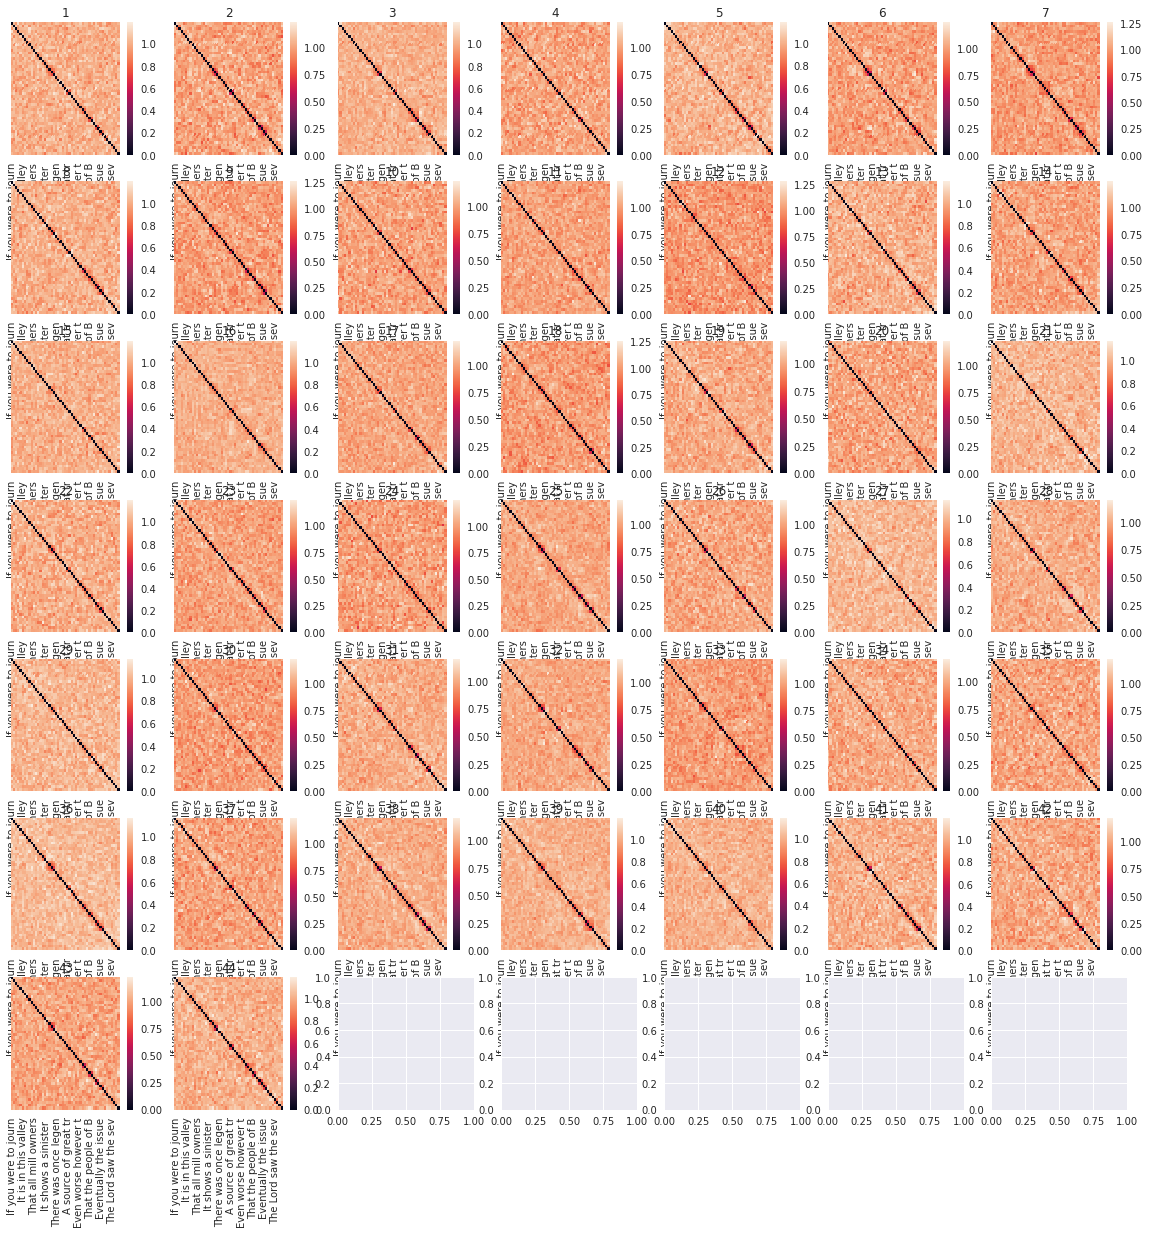

In [51]:
%matplotlib inline
import numpy as np

num_rows_cols = int(np.ceil(np.sqrt(len(boar_data['region']))))
fig, axes = pyplot.subplots(num_rows_cols, num_rows_cols, figsize=(20, 20))

generator = ((boar_data.sel(region=region), region.values) for region in boar_data['region'])
plot_rdms(generator, axes.flatten())

pyplot.savefig('results/RDM-neural.svg')
pyplot.savefig('results/RDM-neural.png')
fig.show()

## Models

In [36]:
% env MKL_THREADING_LAYER=GNU
models = ['skip-thoughts', 'lm_1b']#, 'rntn']
stories = ['Boar', 'MatchstickSeller', 'KingOfBirds', 'Elvis', 'HighSchool']

env: MKL_THREADING_LAYER=GNU


### Model RDMs

DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.models.get_activations/model_name=skip-thoughts,stimulus_set_name=naturalistic-neural-reduced.Boar.pkl


DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.models.get_activations/model_name=lm_1b,stimulus_set_name=naturalistic-neural-reduced.Boar.pkl


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


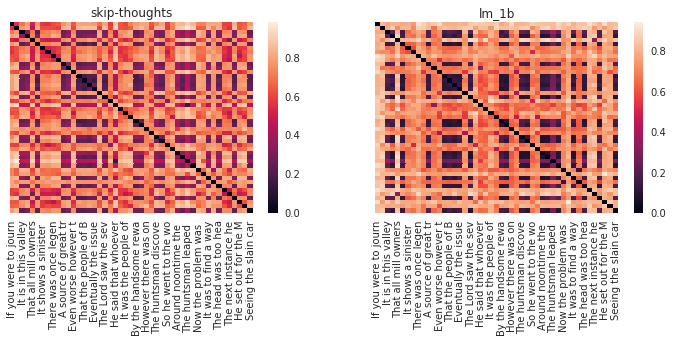

In [52]:
% matplotlib inline

from matplotlib import pyplot

from neural_nlp.models import get_activations
from neural_nlp.stimuli import load_stimuli
from mkgu.metrics.rdm import RDM

rdm = RDM()

def model_rdm_generator(dataset_name):
    for model_name in models:
        encodings = get_activations(model_name, dataset_name)  # feed in sentences in context, i.e. with continuity
        similarities = rdm(encodings)
        yield similarities, model_name

fig, axes = pyplot.subplots(1, len(models), figsize=(12, 3.5))
dataset_name = 'naturalistic-neural-reduced.Boar'
plot_rdms(model_rdm_generator(dataset_name), axes)
pyplot.savefig('results/RDM-{}.svg'.format(dataset_name))
pyplot.savefig('results/RDM-{}.png'.format(dataset_name))
fig.show()


### Inter-model similarity

DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.models.get_activations/model_name=skip-thoughts,stimulus_set_name=naturalistic-neural-reduced.Boar.pkl


DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.models.get_activations/model_name=lm_1b,stimulus_set_name=naturalistic-neural-reduced.Boar.pkl


{('skip-thoughts', 'lm_1b'): 0.818779828767723}
DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.models.get_activations/model_name=skip-thoughts,stimulus_set_name=naturalistic-neural-reduced.MatchstickSeller.pkl


DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.models.get_activations/model_name=lm_1b,stimulus_set_name=naturalistic-neural-reduced.MatchstickSeller.pkl


{('skip-thoughts', 'lm_1b'): 0.8688053853839458}
DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.models.get_activations/model_name=skip-thoughts,stimulus_set_name=naturalistic-neural-reduced.KingOfBirds.pkl


DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.models.get_activations/model_name=lm_1b,stimulus_set_name=naturalistic-neural-reduced.KingOfBirds.pkl


{('skip-thoughts', 'lm_1b'): 0.8087146051949425}
DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.models.get_activations/model_name=skip-thoughts,stimulus_set_name=naturalistic-neural-reduced.Elvis.pkl


DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.models.get_activations/model_name=lm_1b,stimulus_set_name=naturalistic-neural-reduced.Elvis.pkl


{('skip-thoughts', 'lm_1b'): 0.7855673463309919}
DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.models.get_activations/model_name=skip-thoughts,stimulus_set_name=naturalistic-neural-reduced.HighSchool.pkl


DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.models.get_activations/model_name=lm_1b,stimulus_set_name=naturalistic-neural-reduced.HighSchool.pkl


{('skip-thoughts', 'lm_1b'): 0.8988887026015543}


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


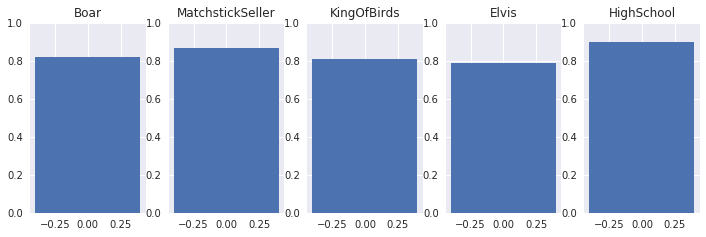

In [52]:
import itertools
import numpy as np
from mkgu.metrics.rdm import RDM, RDMCorrelationCoefficient

similarity = RDMCorrelationCoefficient()
model_combinations = list(itertools.combinations(models, 2))

fig, axes = pyplot.subplots(1, len(stories), figsize=(12, 3.5))
for story, ax in zip(stories, axes):
    scores = {}
    for models in model_combinations:
        encodings = (get_activations(model, 'naturalistic-neural-reduced.{}'.format(story)) for model in models)
        similarities = [rdm(encoding) for encoding in encodings]
        score = similarity(*similarities, rdm_dim='stimulus')
        scores[models] = np.asscalar(score.values)
    print(scores)
    x, y = list(scores.keys()), list(scores.values())
    ax.bar(range(len(x)), y)#, tick_label=x)
    ax.set_ylim(0, 1)
    ax.set_title(story)
fig.show()
pyplot.savefig('results/scores-intermodel.svg')
pyplot.savefig('results/scores-intermodel.png')

## Model-region similarities

DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.run/model=skip-thoughts,stimulus_set=naturalistic-neural-reduced.Boar.pkl


DEBUG:neural_nlp.utils.store:Loading from storage: /mnt/c/Users/Martin/workspaces/tenenbaum/neural-nlp/neural_nlp/../output/neural_nlp.run/model=lm_1b,stimulus_set=naturalistic-neural-reduced.Boar.pkl


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


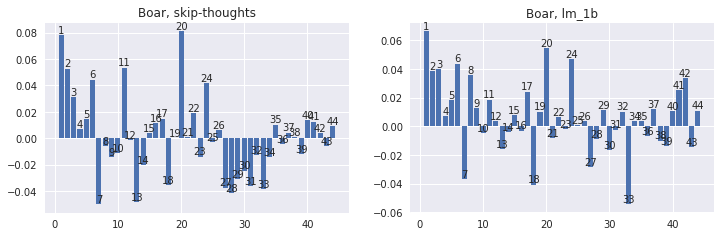

In [57]:
import numpy as np
from neural_nlp import run

fig, axes = pyplot.subplots(1, len(models), figsize=(12, 3.5))

for i, story in enumerate(stories[0:1]):
    for j, model in enumerate(models):
        ax = axes[j]
        ax.set_title("{}, {}".format(story, model))
        scores = run(model, 'naturalistic-neural-reduced.{}'.format(story))
        np.testing.assert_array_equal(scores.dims, ['region'])
        bar = ax.bar(scores['region'].values, scores.values)
    
        for rect, region in zip(bar.patches, scores['region']):
            ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height(), 
                    region.values, ha='center', va='bottom')

pyplot.savefig('results/scores-{}.svg'.format(dataset_name))
pyplot.savefig('results/scores-{}.png'.format(dataset_name))
fig.show()
